<font size="6">Векторные представления слов</font>

## Алгоритм word2vec

Для работы с алгоритмами машинного обучения нужен некоторый способ векторизации — представления текста в виде набора числовых признаков. Ранее мы рассматривали методы "мешок слов" и TF-IDF, которые позволяют получить счетные векторы.

❌ Признаковое пространство имеет размерность, равную мощности словаря,
т.е. тысячи и десятки тысяч. Эта размерность растёт вместе с ростом словаря.

❌ Никак не учитывается семантическая близость слов, все векторы одинаково далеки друг от друга в признаковом пространстве.

Сегодня мы познакомимся со сжатыми векторными представлениями слов (word embeddings).

✅ Строятся в пространствах фиксированной размерности порядка десятков и сотен.

✅ Для семантически близких слов близки как векторы (например, по косинусной мере).

<center><img src ="https://i.ibb.co/NVy0YMs/w2v-example.png" width="350"></center>

**Word2vec** — группа алгоритмов для получения векторных представлений слов.

[T. Mikolov, K. Chen, G. Corrado, J. Dean(2013) Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)

Две модели:
- **Continuous Bag-of-Words (CBOW)** предсказывает текущее слово на основе его контекста (окружающих слов);

- **Skip-gram** предсказывает контекст (окружающие слова) на основе текущего слова.

<center><img src ="https://i.ibb.co/WWfJ20B/cbow-skipgram.png" width="750"></center>

Обе модели решают задачу многоклассовой классификации с помощью персептрона с одним скрытым слоем. Для каждого слова в словаре мы должны получить вероятность, что оно соответствует данному контексту или само является контекстом.

При обучении модели происходит оптимизация весов. Именно они впоследствии используются как векторные представления слов.

<center><img src ="https://i.ibb.co/JsZrX2C/architecture.png" width="350"></center>

## Skip-gram

Рассмотрим получение сжатых векторных представлений на примере модели Skip-gram, поскольку она чаще используется на практике и дает лучшие результаты.

### Теоретическая часть

Пусть наш корпус состоит из одного предложения. Размер окна контекста — 1, смотрим на одно слово слева и одно слово справа.

📌 Каким будет размер словаря?

<center><img src ="https://i.ibb.co/w427P7D/corpus1.png" width="700"></center>

1) На вход мы подаем one-hot вектор $x$ для слова "passes" размера $V$.

2) Входной вектор умножается на матрицу со случайными значениями $W_{input}$ размера $V \times N$, где $V$ — размер словаря, $N$ — размер будущих эмбеддингов, который устанавливается самостоятельно (для больших моделей 300). После завершения обучения строки этой матрицы будут соответствовать сжатым векторам слов.

3) В результате перемножения получаем вектор $h$ размера $N$. Это внутреннее представление модели о слове "passes".

4) Получившийся ранее вектор $h$ умножается на новую матрицу со случайными значениями $W_{output}^T$ размера $N \times V$.

5) В результате перемножения получаем некоторый вектор размера $V$. Применяем к нему функцию активации softmax, после чего получаем новый вектор  $y_{pred}$. Он содержит вероятности для каждого слова быть контекстом входного слова "passes".

6) Подсчитаем ошибку для предсказанных значений. Для этого из вектора $y_{pred}$ вычтем вектор правильных ответов $y_{true}$.

7) Затем мы складываем два получившихся вектора и получаем суммированную ошибку.

<center><img src ="https://i.ibb.co/rvVdjVZ/skipgram.png" width="900"></center>

#### Forward

Умножение вектора на веса скрытого слоя

<center><img src ="https://i.ibb.co/L140YB7/sg-f-1.png" width="650"></center>

Умножение вектора (результата скрытого слоя) на веса выходного слоя

<center><img src ="https://i.ibb.co/b7mkJz6/sg-f-2.png" width="650"></center>

#### Backward

Подсчет суммированной ошибки

<center><img src ="https://i.ibb.co/JCvqJWN/sg-b-1.png" width="750"></center>

Подсчет градиента для $W_{input}$

<center><img src ="https://i.ibb.co/cT1fKCx/sg-b-2.png" width="900"></center>

Подсчет градиента для $W^T_{output}$

<center><img src ="https://i.ibb.co/8jBD7TP/sg-b-3.png" width="550"></center>

Обновление весов (градиентный спуск)

<center><img src ="https://i.ibb.co/X4bMqZf/sg-b-4.png" width="900"></center>

📌 В чем проблема такого подхода?

### Практическая часть

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd
import numpy as np
from sklearn import decomposition

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Подготовка данных

Определим наш небольшой корпус.

In [ ]:
corpus = [
    'drink milk',
    'drink cold water',
    'drink cold cola',
    'drink juice',
    'drink cola',
    'eat bacon',
    'eat mango',
    'eat cherry',
    'eat apple',
    'juice with sugar',
    'cola with sugar',
    'mango is fruit',
    'apple is fruit',
    'cherry is fruit',
    'Berlin is Germany',
    'Boston is USA',
    'Mercedes from Germany',
    'Mercedes is a car',
    'Ford from USA',
    'Ford is a car'
]

Напишем функцию для предобработки одного предложения. Разделим предложение по словам (`.split()`) и удалим слоп-слова (`not in stop_words`).

In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = [token for token in text.split() if token not in stop_words]
    return tokens

Применим предобработку ко всем предложениям корпуса.

In [ ]:
corpus = [preprocess(sentence) for sentence in corpus]
print(corpus)

[['drink', 'milk'], ['drink', 'cold', 'water'], ['drink', 'cold', 'cola'], ['drink', 'juice'], ['drink', 'cola'], ['eat', 'bacon'], ['eat', 'mango'], ['eat', 'cherry'], ['eat', 'apple'], ['juice', 'sugar'], ['cola', 'sugar'], ['mango', 'fruit'], ['apple', 'fruit'], ['cherry', 'fruit'], ['Berlin', 'Germany'], ['Boston', 'USA'], ['Mercedes', 'Germany'], ['Mercedes', 'car'], ['Ford', 'USA'], ['Ford', 'car']]


Создадим словарь уникальных токенов `vocabulary` класса `Counter`.

Добавление токенов осуществляется с помощью метода `update` (см. [пример](https://www.geeksforgeeks.org/python-counter-update-method/)).

In [ ]:
vocabulary = Counter()
for sentence in corpus:
  vocabulary.update(sentence)
print(f'Словарь уникальных токенов:\n{vocabulary}')
print(f'Всего уникальных токенов:{len(vocabulary)}')

Словарь уникальных токенов:
Counter({'drink': 5, 'eat': 4, 'cola': 3, 'fruit': 3, 'cold': 2, 'juice': 2, 'mango': 2, 'cherry': 2, 'apple': 2, 'sugar': 2, 'Germany': 2, 'USA': 2, 'Mercedes': 2, 'car': 2, 'Ford': 2, 'milk': 1, 'water': 1, 'bacon': 1, 'Berlin': 1, 'Boston': 1})
Всего уникальных токенов:20


Cоздадим словарь с индексами `word2id`: каждому слову (ключу) присвоим его порядковый номер (значение) — размер текущего словаря.

In [ ]:
word2id = {}
for word in vocabulary:
  word2id[word] = len(word2id)
# word2id = {word: i for i, word in enumerate(vocabulary)}
print(f'Словарь соответствия токенов и индексов:\n{word2id}')

Словарь соответствия токенов и индексов:
{'drink': 0, 'milk': 1, 'cold': 2, 'water': 3, 'cola': 4, 'juice': 5, 'eat': 6, 'bacon': 7, 'mango': 8, 'cherry': 9, 'apple': 10, 'sugar': 11, 'fruit': 12, 'Berlin': 13, 'Germany': 14, 'Boston': 15, 'USA': 16, 'Mercedes': 17, 'car': 18, 'Ford': 19}


Для обучения модели skip-gram необходимо на вход подавать центральное слово и на выходе получать одно из слов контекста в заданном диапазоне (`window`). Создадим датафрейм, где будет две колонки: `Input` — центральное слово, `Output` — слово контекста.

In [ ]:
def prepare_data(corpus, window):
    columns = ['Input', 'Output']
    result = pd.DataFrame(columns = columns)
    for sentence in corpus:
        for i, input_word in enumerate(sentence):
            for n in range(1, window+1):
                # смотрим контекст слева
                if (i-n)>=0:
                    output_word = sentence[i-n]
                    result.loc[len(result)] = [input_word,output_word]
                # смотрим контекст справа
                if (i+n)<len(sentence):
                    output_word = sentence[i+n]
                    result.loc[len(result)] = [input_word,output_word]
    return result

In [ ]:
train_emb = prepare_data(corpus, window = 2)
print(f"Number of rows: {train_emb.shape[0]}")
train_emb.head(10)

Number of rows: 48


,Input,Output
0,drink,milk
1,milk,drink
2,drink,cold
3,drink,water
4,cold,drink
5,cold,water
6,water,cold
7,water,drink
8,drink,cold
9,drink,cola


В получившемся датафрейме заменим слова на их индексы из словаря `word2id`.

In [ ]:
train_emb.Input = train_emb.Input.map(word2id)
train_emb.Output = train_emb.Output.map(word2id)
train_emb.head(10)

,Input,Output
0,0,1
1,1,0
2,0,2
3,0,3
4,2,0
5,2,3
6,3,2
7,3,0
8,0,2
9,0,4


#### Обучение модели

Укажем размер эмбеддингов и размер словаря.

In [ ]:
embedding_dim = 5
vocab_size = len(vocabulary)

Поскольку в нашем корпусе мало примеров, нам необходимо самостоятельно инициализировать веса небольшими значениями. Матрица `W_input` содержит веса скрытого слоя, матрица `W_output` — веса выходного слоя.

`Variable` — это надстройка над `Tensor`, которая позволяет подсчитывать градиенты для обратного распространения ошибки.

In [ ]:
torch.manual_seed(0)
initrange = 0.5 / embedding_dim
W_input = Variable(torch.randn(vocab_size, embedding_dim).uniform_(-initrange, initrange).float(),
                   requires_grad=True) # V x N
W_output = Variable(torch.randn(embedding_dim, vocab_size).uniform_(-initrange, initrange).float(),
                    requires_grad=True) # N x V
print(f"W_input:\n{W_input}")
print(f"Shape of W_input: {W_input.shape}")
print(f"W_output:\n{W_output}")
print(f"Shape of W_output:{W_output.shape}")

W_input:
tensor([[-0.0249,  0.0045,  0.0146,  0.0237,  0.0392],
        [ 0.0060, -0.0488,  0.0473, -0.0959, -0.0593],
        [-0.0250, -0.0487, -0.0350, -0.0820, -0.0213],
        [ 0.0214, -0.0651, -0.0051,  0.0716, -0.0103],
        [ 0.0028, -0.0086,  0.0202,  0.0636,  0.0947],
        [ 0.0635,  0.0949, -0.0072, -0.0898, -0.0474],
        [ 0.0681, -0.0006, -0.0497, -0.0766, -0.0936],
        [-0.0844, -0.0203,  0.0548,  0.0541, -0.0964],
        [ 0.0624, -0.0783, -0.0211, -0.0405, -0.0193],
        [-0.0196, -0.0897, -0.0863, -0.0156,  0.0013],
        [-0.0454,  0.0377, -0.0900, -0.0067,  0.0879],
        [-0.0408,  0.0903,  0.0362, -0.0902,  0.0633],
        [-0.0115, -0.0446,  0.0800, -0.0808,  0.0107],
        [-0.0209,  0.0714,  0.0279,  0.0481,  0.0353],
        [-0.0240, -0.0210, -0.0824,  0.0542,  0.0794],
        [ 0.0684, -0.0705,  0.0045, -0.0705, -0.0550],
        [-0.0583,  0.0342, -0.0596, -0.0022,  0.0042],
        [ 0.0645, -0.0756, -0.0687, -0.0581,  0.0700],
 

- Определим количество эпох и скорость обучения

- Зададим функцию потерь для многоклассовой классификации

In [ ]:
num_epochs = 1000
learning_rate = 0.2
lr_decay = 0.99
criterion = nn.CrossEntropyLoss()
loss_hist = []

Напишем цикл для обучения по количеству эпох.

- Переведем данные `x` в one-hot тезнор `input_tensor`

- Скрытый слой: умножим входной тензор на матрицу весов `W_input` (матричное умножение: `.mm()` или`@`)

- Выходной слой: умножим результат скрытого слоя на матрицу весов `W_output`

- Применим функцию потерь, которую определили ранее (`criterion`)

- Запустим метод обратного распространения ошибки

- Будем самостоятельно обновлять веса методом градиентного спуска, обновляя значения весов матриц `W_input` и `W_output`

- Изначально мы задали довольно высокую скорость обучения. Будем уменьшать скорость обучения для каждой 10-й эпохи

- Будем выводить значение функции потерь для каждой 50-й эпохи

In [ ]:
%%time
for epoch in range(num_epochs):
    for x,y in zip(torch.tensor([train_emb.Input.values]), torch.tensor([train_emb.Output.values])):

        # one-hot кодирование входного вектора
        input_tensor = F.one_hot(x).type(torch.Tensor)

        # скрытый слой 1 x N: умножение входного вектора на матрицу W_input
        h = input_tensor @ W_input
        #h = input_tensor.mm(W_input)

        # выходной слой 1 x V: умножение результата скрытого слоя на матрицу W_output
        y_pred = h @ W_output
        #y_pred = h.mm(W_output)

        # функция потерь
        loss = criterion(y_pred, y)

        # обратное распространение ошибки
        loss.backward()

        # обновление весов с помощью метода градиентного спуска
        with torch.no_grad():
            W_input[x, :] -= learning_rate * W_input.grad.data[x, :]
            W_output -= learning_rate * W_output.grad.data
            W_input.grad.data.zero_()
            W_output.grad.data.zero_()

    # для каждой 10-й эпохи будем уменьшать скорость обучения
    if epoch % 10 == 0:
        learning_rate *= lr_decay

    # запишем значение функции потерь
    loss_hist.append(loss)

    # вывод ошибки для каждой 50-й эпохи
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, loss = {loss}')

Epoch 0, loss = 2.9967873096466064
Epoch 50, loss = 2.990715980529785
Epoch 100, loss = 2.9793825149536133
Epoch 150, loss = 2.9500648975372314
Epoch 200, loss = 2.8728926181793213
Epoch 250, loss = 2.7046902179718018
Epoch 300, loss = 2.4823639392852783
Epoch 350, loss = 2.2758967876434326
Epoch 400, loss = 2.09246563911438
Epoch 450, loss = 1.9281407594680786
Epoch 500, loss = 1.7824443578720093
Epoch 550, loss = 1.6649316549301147
Epoch 600, loss = 1.5738917589187622
Epoch 650, loss = 1.5013612508773804
Epoch 700, loss = 1.4416760206222534
Epoch 750, loss = 1.3915802240371704
Epoch 800, loss = 1.3490723371505737
Epoch 850, loss = 1.312686562538147
Epoch 900, loss = 1.2812234163284302
Epoch 950, loss = 1.253725290298462
CPU times: user 1 s, sys: 14.6 ms, total: 1.02 s
Wall time: 1.75 s


Получившиеся векторы имеют размерность 5. Чтобы отобразить их на графике, необходимо уменьшить размерность до 2. Сделаем это с помощью [сингулярного разложения](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

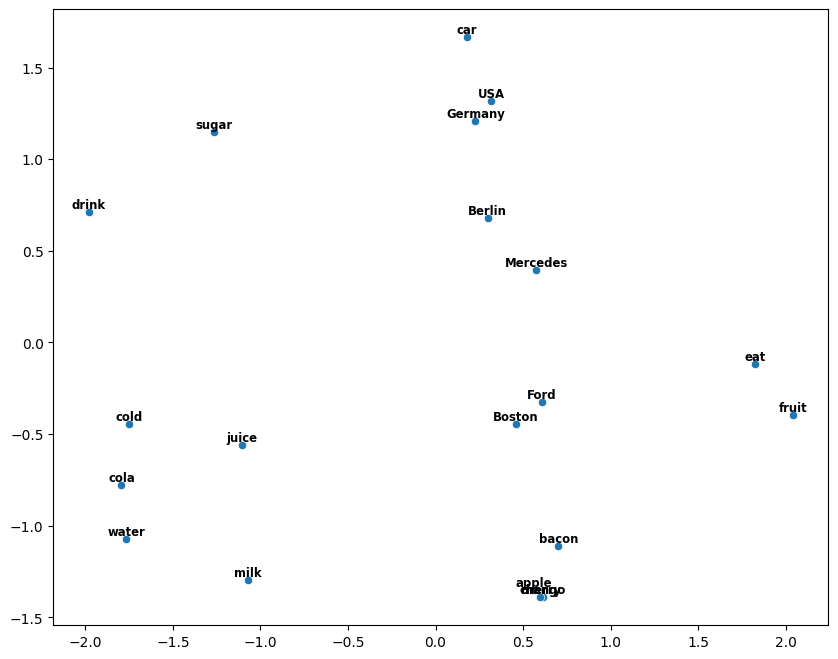

In [ ]:
W_input = W_input.detach().numpy()
svd = decomposition.TruncatedSVD(n_components=2)
W_input_dec = svd.fit_transform(W_input)
x = W_input_dec[:,0]
y = W_input_dec[:,1]
plot = sns.scatterplot(x=x, y=y)

for i in range(0, W_input_dec.shape[0]):
     plot.text(x[i], y[i]+2e-2, list(vocabulary.keys())[i], horizontalalignment='center', size='small', color='black', weight='semibold');

📌 Какие выводы можно сделать о получившихся векторных представлениях?

In [ ]:
print(f"Word2id mapping:\n{word2id}")

Word2id mapping:
{'drink': 0, 'milk': 1, 'cold': 2, 'water': 3, 'cola': 4, 'juice': 5, 'eat': 6, 'bacon': 7, 'mango': 8, 'cherry': 9, 'apple': 10, 'sugar': 11, 'fruit': 12, 'Berlin': 13, 'Germany': 14, 'Boston': 15, 'USA': 16, 'Mercedes': 17, 'car': 18, 'Ford': 19}


Посчитаем косинусное расстояние между векторами слов 'milk' и 'water', 'milk' и 'apple'.

Запишем векторы для этих слов по индексам в матрице `W_input`.

In [ ]:
W_input = torch.Tensor(W_input)
milk = W_input[word2id['milk'], :]
water = W_input[word2id['water'], :]
apple = W_input[word2id['apple'], :]
milk_water = F.cosine_similarity(milk, water, dim=0)
print(f"Cosine similarity between words 'milk' and 'water': {round(milk_water.item(), 2)}")
milk_apple= F.cosine_similarity(milk, apple, dim=0)
print(f"Cosine similarity between words 'milk' and 'apple': {round(milk_apple.item(), 2)}")

Cosine similarity between words 'milk' and 'water': 0.77
Cosine similarity between words 'milk' and 'apple': 0.05


## Negative sampling

Поскольку классический word2vec решает задачу многоклассовой классификации, при обучении модели пересчитываются веса для всех слов в словаре. Чтобы сократить количество вычислений, было предложено использовать бинарную классификацию.

Если раньше необходимо было предсказывать контекст для слова, то теперь для двух слов необходимо предсказать, являются они соседними или нет.

<center><img src ="https://i.ibb.co/NNB4XcQ/from.png" width="400"></center>
<center><img src ="https://i.ibb.co/2vGfSy9/to.png" width="400"></center>

📌 Какая проблема возникнет, если для обучения использовать только положительные примеры? Как ее решить?

Теперь корпус выглядит по-другому: на вход мы подаем пары слов и метку 1 или 0 (являются ли они соседними).

Чтобы получить примеры отрицательного класса,
для каждого целевого слова в пару добавляются случайные слова, которые не являются соседними. На каждый правильный пример добавляется от 5 до 20 неправильных.

<center><img src ="https://i.ibb.co/7rjSfZp/input-output.png" width="600"></center>

Пусть теперь наш корпус выглядит следующим образом:

<center><img src ="https://i.ibb.co/WKsSD4Y/corpus2.png" width="750"></center>

Установим гиперпараметры: размер окна — 2, количество отрицательных примеров — 3. Для первого слова "Ned" слово положительного класса — "Stark", слова отрицательного класса — "pimples", "zebra", "idiot".

### Forward

Умножение вектора на веса скрытого слоя

<center><img src ="https://i.ibb.co/KWjbsJh/ns-f-1.png" width="600"></center>

Умножение вектора (результата скрытого слоя) на веса выходного слоя. Применяем функцию активации (сигмоиду).

<center><img src ="https://i.ibb.co/VwSdzCh/ns-f-2.png" width="700"></center>

### Backward

Вычитаем значения меток классов из получившихся вероятностей.

<center><img src ="https://i.ibb.co/ysrnQ7n/ns-b-1.png" width="500"></center>

Подсчет градиента для $W_{input}$

<center><img src ="https://i.ibb.co/gRZ4r4d/ns-b-2.png" width="750"></center>

Подсчет градиента для $W^T_{output}$

<center><img src ="https://i.ibb.co/bsBPWy3/ns-b-3.png" width="650"></center>

Обновление весов

<center><img src ="https://i.ibb.co/z4KR0qZ/ns-b-4.png" width="950"></center>

## fastText

📌 Какие недостатки есть у word2vec?

FastText позволяет получить векторные представления не для целых слов, а для n-грамм.

- Содержат морфологическую информацию
- Решение для слов, которых нет в словаре

[P. Bojanowski, E. Grave, A. Joulin ,T. Mikolov (2017). Enriching Word Vectors with Subword Information](https://arxiv.org/pdf/1607.04606v2.pdf)

<center><img src ="https://i.ibb.co/D4HZ4dR/ngrams.png" width="350"></center>

Размер n-грамм — гипермараметр. Все n-граммы ранжируются и берутся только самые частотные (первые несколько миллионов).

<center><img src ="https://i.ibb.co/8Dvyp8r/fasttext.png" width="600"></center>

## Библиотека gensim

Для своих индивидуальных нужд и экспериментов бывает полезно самому натренировать модель на нужных данных и с нужными параметрами. Но для каких-то общих целей модели уже есть.

Использовать предобученную модель эмбеддингов или обучить свою можно с помощью библиотеки [gensim](https://radimrehurek.com/gensim/models/word2vec.html).

In [ ]:
!pip install gensim -q

In [ ]:
import gensim

Загрузим предобученную модель от Google. Модель включает в себя векторы для 3 миллионов слов и обучалась на 100 миллиардах слов из набора данных Google News. Длина вектора равна 300.

In [ ]:
!wget -q https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/datasets/GoogleNews-vectors-negative300.bin.gz

Для загрузки предобученных векторных представлений используется класс [KeyedVectors](https://radimrehurek.com/gensim/models/keyedvectors.html).

In [ ]:
from gensim.models import KeyedVectors
google_news_model = KeyedVectors.load_word2vec_format(f'GoogleNews-vectors-negative300.bin.gz', binary=True)

Протестируем загруженные векторные представления.

### Подсчет косинусной меры близости

Для оценки семантической схожести векторов используется мера под названием «косинусная близость». Фактически это косинус угла между векторами — скалярное произведение этих векторов, разделенное на произведение их длин.

Чем больше значение косинусной меры, тем ближе друг к другу векторы.

<center><img src ="https://i.ibb.co/4gkSDNx/cosine-similarity.png" width="550"></center>

В библиотеке gensim есть встроенная функция [similarity](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.similarity.html).

In [ ]:
print(f"Gensim cosine similarity between 'coffee' and 'tea': \
{round(google_news_model.similarity('coffee','tea').item(), 2)}")

Gensim cosine similarity between 'coffee' and 'tea': 0.56


In [ ]:
print(f"Size of vector 'coffee': {google_news_model['coffee'].shape}")
print(f"Size of vector 'tea': {google_news_model['tea'].shape}")

Size of vector 'coffee': (300,)
Size of vector 'tea': (300,)


Можем написать собственную функцию для подсчета косинусной близости и сравнить результат с встроенной функцией.

In [ ]:
import numpy as np
from numpy.linalg import norm

def cos_similarity(model, word1, word2):
  a = model[word1]
  b = model[word2]
  cos_sim = np.dot(a, b)/(norm(a)*norm(b))
  return cos_sim

In [ ]:
print(f"Custom cosine similarity between 'coffee' and 'tea': \
{round(cos_similarity(google_news_model, 'coffee','tea').item(), 2)}")

Custom cosine similarity between 'coffee' and 'tea': 0.56


Посчитаем косинусную меру для слов "мяч" и "крокодил" двумя способами

In [ ]:
print(f"Gensim cosine similarity between 'ball' and 'crocodile': \
{round(google_news_model.similarity('ball','crocodile').item(), 2)}")

Gensim cosine similarity between 'ball' and 'crocodile': 0.1


In [ ]:
print(f"Custom cosine similarity between 'ball' and 'crocodile': \
{round(cos_similarity(google_news_model, 'ball','crocodile').item(), 2)}")

Custom cosine similarity between 'ball' and 'crocodile': 0.1


### Семантически близкие слова

С помощью word2vec можно найти *n* самых похожих слов для некоторого целевого слова. Для этого нужно вычислить косинусную близость между вектором заданного слова и векторами каждого слова в модели.

Воспользуемся функцией [most_similar](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html) из библиотеки gensim.

In [ ]:
print(f"Top-5 most similar words to 'cat':")
for x in google_news_model.most_similar('cat', topn=5):
    print(f"{x[0]} {round(x[1], 2)}")

Top-5 most similar words to 'cat':
cats 0.81
dog 0.76
kitten 0.75
feline 0.73
beagle 0.72


Найдем ближайшие понятия для прилагательных "плохой" и "хороший".

In [ ]:
print(f"Top-5 most similar words to 'bad':")
for x in google_news_model.most_similar('bad', topn=5):
    print(f"{x[0]} {round(x[1], 2)}")

Top-5 most similar words to 'bad':
good 0.72
terrible 0.68
horrible 0.67
Bad 0.67
lousy 0.66


In [ ]:
print(f"Top-5 most similar words to 'good':")
for x in google_news_model.most_similar('good', topn=5):
    print(f"{x[0]} {round(x[1], 2)}")

Top-5 most similar words to 'good':
great 0.73
bad 0.72
terrific 0.69
decent 0.68
nice 0.68


### Семантические пропорции (аналогии)

Также можно осуществить векторную арифметику: складывать и вычитать вектора нескольких слов. Например, сложив два вектора и вычтя из них третий вектор, мы можем решить своеобразную пропорцию.

Для реализации семантических аналогий также используется метод [most_similar](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html). Он выполняет сложение положительных векторов (`positive`) и вычитание отрицательных (`negative`). Затем из полученной позиции выводится список ближайших известных векторов.

<center><img src ="https://i.ibb.co/ysPWz5x/analogies.png" width="900"></center>

king - man + woman = ?

In [ ]:
print(f"king - man + woman = \
{google_news_model.most_similar(positive=['king','woman'], negative=['man'], topn=1)[0][0]}")

king - man + woman = queen


Построим следующие аналогии:
- для глагольных форм: swimming - walking + walked = ?
- для стран и городов: Turkey - Russia + Moscow = ?

In [ ]:
print(f"swimming - walking + walked = \
{google_news_model.most_similar(positive=['swimming','walked'], negative=['walking'], topn=1)[0][0]}")

swimming - walking + walked = swam


In [ ]:
print(f"Turkey - Russia + Moscow = \
{google_news_model.most_similar(positive=['Turkey','Moscow'], negative=['Russia'], topn=1)[0][0]}")

Turkey - Russia + Moscow = Ankara


### Поиск лишнего слова по смыслу

Наконец, мы можем найти лишнее по смыслу слово в группе слов. Лишним словом является то, вектор которого наиболее удален от других векторов слов.
- вычисляется среднее значение всех слов-векторов (центр);
- вычисляется косинусное расстояние от  центра до каждого слова;
- возвращается единственное слово с наибольшим косинусным расстоянием от центра.

Обратите внимание, что используется именно косинусное расстояние, а не косинусная близость.

$distance (A, B) = 1 – similarity(A, B)$

Чем больше расстояние между векторами, тем меньше семантическое сходство.

<center><img src ="https://i.postimg.cc/rwx8dXMW/doesnt-match.png" width="550"></center>

Это можно осуществить с помощью функции [doesnt_match](https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.doesnt_match.html).

In [ ]:
words = ['friday', 'saturday', 'sunday', 'weekday', 'spoon']
print(f"The word '{google_news_model.doesnt_match(words)}' \
from the given list {words} doesn’t go with the others.")

The word 'spoon' from the given list ['friday', 'saturday', 'sunday', 'weekday', 'spoon'] doesn’t go with the others.


Найдем лишнее по смыслу слово в следующих группах:
- prince, king, fork, queen, castle
- dinner, breakfast, cereal, lunch

In [ ]:
words = ['prince', 'king', 'fork', 'queen', 'castle']
print(f"The word '{google_news_model.doesnt_match(words)}' \
from the given list {words} doesn’t go with the others.")

The word 'fork' from the given list ['prince', 'king', 'fork', 'queen', 'castle'] doesn’t go with the others.


In [ ]:
words = ['dinner', 'breakfast', 'cereal', 'lunch']
print(f"The word '{google_news_model.doesnt_match(words)}' \
from the given list {words} doesn’t go with the others.")

The word 'cereal' from the given list ['dinner', 'breakfast', 'cereal', 'lunch'] doesn’t go with the others.


## Кластеризация

Кластеризация — это задача разбиения множества объектов на группы, называемые кластерами. Внутри каждой группы должны оказаться «похожие» объекты, а объекты разных группы должны быть как можно более отличны. Главное отличие кластеризации от классификации состоит в том, что перечень групп четко не задан и определяется в процессе работы алгоритма.

Будем осуществлять кластеризацию для текстов новостных статей.

<center><img src ="https://i.postimg.cc/5098tmdc/text-clustreing.webp" width="600"></center>

### Загрузка данных

In [ ]:
!wget https://raw.githubusercontent.com/Xeanst/NLP_course_FBB/main/data/articles_data.csv

--2024-10-23 12:13:41--  https://raw.githubusercontent.com/Xeanst/NLP_course_FBB/main/data/articles_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7690867 (7.3M) [text/plain]
Saving to: ‘articles_data.csv’

articles_data.csv   100%[===================>]   7.33M  46.8MB/s    in 0.2s    

2024-10-23 12:13:42 (46.8 MB/s) - ‘articles_data.csv’ saved [7690867/7690867]



In [ ]:
import pandas as pd
df_raw = pd.read_csv("articles_data.csv")
df_raw.head()

,Unnamed: 0,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
0,0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0
1,1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0
2,2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,NaN
3,3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0
4,4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0


Интересующие нас колонки: заголовок (title), описание (description) и содержание (content).

Создадим новый датафрейм с одной колонкой "текст", куда добавим объединенное содержимое этих трех колонок.

In [ ]:
text_columns = ["title", "description", "content"]
df = df_raw.loc[:,text_columns]

for col in text_columns:
    df[col] = df[col].astype(str)

df["text"] = df[text_columns].apply(lambda x: " | ".join(x), axis=1)
df.head()

,title,description,content,text
0,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,WASHINGTON (Reuters) - The National Transporta...,NTSB says Autopilot engaged in 2018 California...
1,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,The States jobless rate fell to 5.2 per cent l...,Unemployment falls to post-crash low of 5.2% |...
2,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,Louise Kennedy is showing off her autumn-winte...,"Louise Kennedy AW2019: Long coats, sparkling t..."
3,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,"Han Kwang Song, the first North Korean footbal...",North Korean footballer Han joins Italian gian...
4,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",nan,UK government lawyer says proroguing parliamen...


### Предобработка текста

In [ ]:
import re
import string
import numpy as np
import nltk
nltk.download("punkt")
from nltk import word_tokenize
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
custom_stopwords = set(stopwords.words("english") + ["news", "new", "top"])

def clean_text(text, tokenizer, stopwords):

    text = text.lower() # приводим к нижнему регистру
    text = re.sub(r"\[(.*?)\]", "", text)  # удаляем слова в квадратных скобках как [+300 chars]
    text = re.sub(r"\s+", " ", text)  # удаляем множественный пробел, табуляцию и перенос строки
    text = re.sub(r"\w+…|…", "", text)  # удаляем многоточие
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text) # заменяем дефис на пробел
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # удаляем пунктуацию

    tokens = tokenizer(text) # токенизируем
    tokens = [t for t in tokens if not t in stopwords]  # удаляем стоп-слова
    tokens = ["" if t.isdigit() else t for t in tokens]  # удаляем числа
    tokens = [t for t in tokens if len(t) > 1]  # удаляем токены длины 1
    return tokens

In [ ]:
df["tokens"] = df["text"].map(lambda x: clean_text(x, word_tokenize, custom_stopwords))

# удаляем пустые значения и сохраняем два столбца: тексты и токены
df = df.loc[df.tokens.map(lambda x: len(x) > 0), ["text", "tokens"]]

# удаляем дубликаты строк
import numpy as np
_, idx = np.unique(df["tokens"], return_index=True)
df = df.iloc[idx, :]

docs = df["text"].values
tokenized_docs = df["tokens"].values

print(f"Исходные данные: {df_raw.shape}")
print(f"Данные после предобработки: {df.shape}")
df.head()

Исходные данные: (10437, 15)
Данные после предобработки: (9883, 2)


,text,tokens
8155,12th man arrested in statutory rape case at Al...,"[12th, man, arrested, statutory, rape, case, a..."
350,The 18th-Century Paris Apartment That Elegantl...,"[18th, century, paris, apartment, elegantly, b..."
8041,A 19th-Century Home in Brooklyn Gets a 21st-Ce...,"[19th, century, home, brooklyn, gets, 21st, ce..."
4742,1Xtra's DJ Ace needs new kidney | The DJ and p...,"[1xtras, dj, ace, needs, kidney, dj, presenter..."
1071,2nd person in US dies from lung disease linked...,"[2nd, person, us, dies, lung, disease, linked,..."


### Обучение word2vec на данных

Инициализируем модель с помощью модуля [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec). Основные параметры:

- sentences — обучающие данные,
- vector_size — размер вектора (default 100),
- window — размер окна наблюдения (default 5),
- min_count — мин. частотность слова в корпусе (default 5),
- sg — используемый алгоритм обучения (default 0 — CBOW, 1 — Skip-gram),
- workers — количество ядер (default 3),
- alpha — скорость обучения (default 0.025).

In [ ]:
from gensim.models import Word2Vec
articles_model = Word2Vec(sentences=tokenized_docs, workers=1, seed=42)
len(articles_model.wv)

11099

In [ ]:
print(f"Top-5 most similar words to 'president':")
for x in articles_model.wv.most_similar('president', topn=5):
    print(f"{x[0]} {round(x[1], 2)}")

Top-5 most similar words to 'president':
trump 0.97
trumps 0.95
ivanka 0.94
pencil 0.94
impeachment 0.94


In [ ]:
print(f"spain - germany + berlin = ")
for x in articles_model.wv.most_similar(positive=['spain','berlin'], negative=['germany'], topn=6):
    print(f"{x[0]} ({round(x[1], 2)})")

spain - germany + berlin = 
toronto (0.98)
celebration (0.98)
hosts (0.98)
unofficial (0.98)
closer (0.97)
madrid (0.97)


Кластеризация будет осуществляться для документов (новостных статей).

Усредним векторы слов каждого документа, чтобы сгенерировать вектор документа.

- Создаем numpy массив для векторов документов `features`, состоящий из нулей
  - размер массива: количество токенизированных документов $\times$ размер вектора в модели
- Проходим по списку токенизированных документов `tokenized_docs`
  
  - Создаем numpy массив векторов слов `vectors`, состоящий из нулей `np.zeros`
    - размер массива: количество токенов в документе $\times$ размер вектора в модели
  - Проходим по токенам документа `tokens`
    - Если вектор для слова `token` присутствует в модели `model`, добавляем вектор слова в массив `vectors`

  - Считаем среднее `np.mean` для массива `vectors` (с указанием оси), получаем усредненный вектор документа

  - Добавляем полученный вектор в массив `features`

In [ ]:
def doc2vec(tokenized_docs, model):

    features = np.zeros((len(tokenized_docs), model.wv.vector_size))
    for i,tokens in enumerate(tokenized_docs):
        vectors = np.zeros((len(tokens), model.wv.vector_size))
        for j,token in enumerate(tokens):
            if token in model.wv:
                vectors[j] = model.wv[token]
        avg_vec = np.mean(vectors, axis=0)
        features[i] = avg_vec
    return features

In [ ]:
vectorized_docs = doc2vec(tokenized_docs, model=articles_model)
vectorized_docs.shape

(9883, 100)

### Метод k-средних

Метод k-средних используется для кластеризации данных на основе алгоритма разбиения векторного пространства на заранее определенное число кластеров $k$. Алгоритм представляет собой итерационную процедуру, в которой выполняются следующие шаги:

1. Выбирается число кластеров $k$.
2. Из исходного множества данных случайным образом выбираются $k$ наблюдений, которые будут служить начальными центрами кластеров.
3. Для каждого наблюдения исходного множества определяется ближайший к нему центр кластера.
4. Вычисляются центроиды — центры тяжести кластеров. Каждый центроид — это вектор, элементы которого представляют собой средние значения соответствующих признаков, вычисленные по всем записям кластера.
5. Центр кластера смещается в его центроид, после чего центроид становится центром нового кластера.
6. 3-й и 4-й шаги итеративно повторяются. На каждой итерации происходит изменение границ кластеров и смещение их центров. В результате минимизируется расстояние между элементами внутри кластеров и увеличиваются междукластерные расстояния.

Остановка алгоритма производится тогда, когда границы кластеров и расположения центроидов не перестанут изменяться от итерации к итерации, т.е. на каждой итерации в каждом кластере будет оставаться один и тот же набор наблюдений.

<center><img src ="https://i.ibb.co/5FzWHX1/kmeans.png" width="700"></center>

Задача оценки качества кластеризации является более сложной по сравнению с оценкой качества классификации. Нам неизвестны истинные метки объектов, поэтому нужны такие метрики качества, которые можно вычислить по неразмеченной выборке.

Критерий силуэта (англ *Silhouette*) — это метрика, которая не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму неразмеченную выборку и результат кластеризации.

- точки внутри кластера должны лежать очень близко друг к другу, то есть кластер должен быть *плотным*
- сами кластера должны лежать как можно дальше друг от друга

Метрика силуэта позволяет учитывать оба этих факта и показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Меняется в интервале от $-1$ до $1$ (чем выше, тем лучше).

Выберем оптимальное количество кластеров с помощью критерия силуэта. Рассмотрим значения в диапазоне от 2 до 10.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
metrics = -1
for i in range(2,11):
    kmeans = KMeans(n_clusters=i, n_init="auto", random_state=42)
    data = kmeans.fit(vectorized_docs)
    silhouette_avg = silhouette_score(vectorized_docs, data.labels_)
    print(f"For n_clusters = {i} mean Silhouette score is: {silhouette_avg:.2f}")
    if silhouette_avg > metrics:
      metrics = silhouette_avg
      result_data = data
      clusters = i

For n_clusters = 2 mean Silhouette score is: 0.28
For n_clusters = 3 mean Silhouette score is: 0.30
For n_clusters = 4 mean Silhouette score is: 0.20
For n_clusters = 5 mean Silhouette score is: 0.24
For n_clusters = 6 mean Silhouette score is: 0.28
For n_clusters = 7 mean Silhouette score is: 0.26
For n_clusters = 8 mean Silhouette score is: 0.20
For n_clusters = 9 mean Silhouette score is: 0.18
For n_clusters = 10 mean Silhouette score is: 0.18


Наибольшее значение силуэта получаем при 3 кластерах.

Рассмотрим значения метрики для каждого кластера отдельно: среднее значение, минимальное и максимальное.

In [ ]:
sample_silhouette_values = silhouette_samples(vectorized_docs, data.labels_)
silhouette_values = []
for i in range(clusters):
    cluster_silhouette_values = sample_silhouette_values[data.labels_ == i]
    silhouette_values.append((i, cluster_silhouette_values.shape[0], cluster_silhouette_values.mean(), cluster_silhouette_values.min(), cluster_silhouette_values.max(),))
silhouette_values = sorted(silhouette_values, key=lambda tup: tup[2], reverse=True)
for s in silhouette_values:
    print(f"Cluster {s[0]}: size: {s[1]}, mean: {s[2]:.2f}, minimum: {s[3]:.2f}, maximum: {s[4]:.2f}")

Cluster 0: size: 2146, mean: 0.31, minimum: 0.07, maximum: 0.52
Cluster 2: size: 1543, mean: 0.07, minimum: -0.19, maximum: 0.28
Cluster 1: size: 949, mean: 0.04, minimum: -0.14, maximum: 0.27


Рассмотрим наиболее репрезентативные слова для каждого кластера.

In [ ]:
for i in range(clusters):
    tokens_per_cluster = ""
    most_representative = articles_model.wv.most_similar(positive=[kmeans.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Cluster 0: complete brooklyn standing muslims closely 
Cluster 1: groups renewed watchdog kiev demanding 
Cluster 2: aimed raising ties urged adding 


In [ ]:
for i in range(clusters):
  print(f"Cluster {i}:")
  most_representative_docs = np.argsort(
      np.linalg.norm(vectorized_docs - kmeans.cluster_centers_[i], axis=1)
  )
  for d in most_representative_docs[:2]:
    print(docs[d])
    print("-------------")
  print()

Cluster 0:
A top VMware exec explains how it avoided getting crushed by Microsoft in its early days — and the lesson startups can learn from it (VMW, MSFT) | VMware COO Sanjay Poonen says that in its early days, Microsoft could have "obliterated" VMware. Microsoft had created a competing product that worked better with its own Windows operating system. So rather than tackle the challenge head-on, VMware found succ… | In the early days of VMware, Microsoft could well have edged it out of the market, if it weren't for one key strategy. 
 "In some senses, VMware has over the course of time had to navigate among other bigger companies," VMware COO Sanjay Poonen told Business… [+2407 chars]
-------------
What Netflix's 'The Spy' Starring Sacha Baron Cohen Gets Wrong About Eli Cohen | The six-part spy thriller is based on the real-life Israeli spy who infiltrated Syria. | Did you spend your weekend binge-watching Netflix's taut thriller, The Spy? You're not alone.
The six-part drama about Is

## Классификация

Реализуем анализа тональности с помощью многослойного персептрона. Вместо того, чтобы обучать слой `nn.Embeddings`, обучим эмбеддинги заранее с помощью word2vec.

In [ ]:
import numpy as np
import gensim
from gensim.models import Word2Vec

import pandas as pd
from string import punctuation # набор знаков препинания
from collections import Counter # словарь для подсчета объектов

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn # слои
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler # работа с данными
import torch.nn.functional as F # паддинг
from torch.nn.utils.rnn import pad_sequence # паддинг
import torch.optim as optim # оптимизация

### Загрузка данных

В качестве данных будем использовать русскоязычный корпус коротких текстов [RuTweetCorp](https://www.elibrary.ru/item.asp?id=20399632).

Корпус разбит на два класса: твиты с положительной окраской (`positive.csv`) и твиты с отрицательной окраской (`negative.csv`).

---

Twitter — организация, деятельность которой запрещена на территории Российской Федерации.

In [ ]:
!wget https://raw.githubusercontent.com/Xeanst/NN_in_compling/main/03_torch_mlp/positive.csv
!wget https://raw.githubusercontent.com/Xeanst/NN_in_compling/main/03_torch_mlp/negative.csv

--2024-10-23 12:15:55--  https://raw.githubusercontent.com/Xeanst/NN_in_compling/main/03_torch_mlp/positive.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23811619 (23M) [text/plain]
Saving to: ‘positive.csv’

positive.csv        100%[===================>]  22.71M   103MB/s    in 0.2s    

2024-10-23 12:15:59 (103 MB/s) - ‘positive.csv’ saved [23811619/23811619]

--2024-10-23 12:15:59--  https://raw.githubusercontent.com/Xeanst/NN_in_compling/main/03_torch_mlp/negative.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24450

В корпусе указано много разных параметров, но нас будут интересовать только сами тексты (`text`) и тональность (`tone`). Объединим тексты с позитивной и негативной окраской (`all_data`), при этом взяв только нужные столбцы.

In [ ]:
import pandas as pd
positive = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
negative = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11] )
negative['tone'] = 0
all_data = pd.concat([positive[['text','tone']], negative[['text','tone']]], ignore_index=True)
print(len(all_data))
all_data.head()

216130


,text,tone
0,RT @SuetinaqweHh: Моя Дубовскаая приехалааа:**...,1
1,"Наконец-то на улице снег^) Немного, но всё же ...",1
2,какие вы противные!)) пишите тyт вечно про Бар...,1
3,"RT @kejajanekys: у моего бывшего,с которым был...",1
4,до аэробики я и не подозревала о наличии у себ...,1


Разделим данные на обучающую и валидационную выборку.

In [ ]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences = train_test_split(all_data, test_size=0.1, random_state=42)

### Предобработка данных

Убираем пунктуацию, приводим к нижнему регистру и токенизируем

In [ ]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def text_preprocessing(text):
    tokens = [token.strip(punctuation).lower() for token in text.split()]
    return tokens

Создаем словарь уникальных токенов и фильтрованный словарь токенов, встретившихся больше 10 раз.

In [ ]:
from collections import Counter
vocabulary = Counter()
for text in all_data['text']:
    vocabulary.update(text_preprocessing(text))
print('Всего уникальных токенов:', len(vocabulary))
filtered_vocabulary = set()
for word in vocabulary:
  if vocabulary[word] > 10:
    filtered_vocabulary.add(word)
print('Уникальных токенов, вcтретившихся больше 10 раз:', len(filtered_vocabulary))

Всего уникальных токенов: 351664
Уникальных токенов, вcтретившихся больше 10 раз: 16164


Создаем словарь для перевода слов в индексы.

In [ ]:
word2id = {'PAD':0}
for word in filtered_vocabulary:
    word2id[word] = len(word2id)
print(word2id)

{'PAD': 0, '': 1, 'мою': 2, 'зависит': 3, 'них': 4, '6-7': 5, 'закрываются': 6, 'горка': 7, 'врядли': 8, 'о.о': 9, 'встреча': 10, 'души': 11, 'мандаринки': 12, 'тетрадь': 13, 'pamirskyioleg': 14, 'положительные': 15, 'ра': 16, 'прямые': 17, 'брать': 18, 'нетерпением': 19, '2-й': 20, 'стуле': 21, 'попробую': 22, 'android': 23, 'айпада': 24, 'поменяла': 25, 'прошла': 26, 'kepochka': 27, 'ахахахах': 28, 'инет': 29, 'бессонные': 30, 'похожие': 31, 'куришь': 32, 'верю,что': 33, '50': 34, 'запомню': 35, 'отдохнули': 36, 'webcamtoy': 37, 'дождалась': 38, 'последних': 39, 'любимом': 40, 'нарисовали': 41, 'будто': 42, 'масло': 43, 'пишете': 44, 'своём': 45, 'счёт': 46, 'рука': 47, 'вкусная': 48, 'холоде': 49, 'зимние': 50, 'узнают': 51, 'леной': 52, 'кончились': 53, 'пафоса': 54, 'старое': 55, 'нему': 56, 'любителей': 57, 'ожидала': 58, 'разбить': 59, 'irotieva': 60, 'крепче': 61, 'алёна': 62, 'охранник': 63, 'ночные': 64, 'твоими': 65, 'мат': 66, 'ожидается': 67, 'необычный': 68, 'предательств

### Dataset, Sampler, DataLoader

Создаем класс для датасета.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [ ]:
class ToneDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['tone'].values
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        tokens = self.text_preprocessing(self.dataset[index])
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def text_preprocessing(self, text):
        tokens = [token.strip(punctuation).lower() for token in text.split()]
        return tokens

    def collate_fn(self, batch):
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

Определяем Dataset, Sampler и DataLoader.

In [ ]:
train_dataset = ToneDataset(train_sentences, word2id, DEVICE)
val_dataset = ToneDataset(val_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
val_sampler = SequentialSampler(val_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

Посмотрим, как выглядит первая выдача `train_iterator` в цикле.

In [ ]:
batch = next(iter(train_iterator))
print(batch)
print(len(batch))
print(batch[0].shape) # [количество текстов в батче, количество слов в тексте]
print(batch[1].shape) # [количество меток в батче, количество меток для текста]

(tensor([[ 3962,  1784, 12507,  ...,     0,     0,     0],
        [ 1773,   884,  3498,  ...,     0,     0,     0],
        [ 7756,  2798, 13084,  ...,     0,     0,     0],
        ...,
        [ 7030, 12477, 12279,  ...,     0,     0,     0],
        [13293,  8429,  2956,  ...,     0,     0,     0],
        [15918,  8429,  9476,  ...,     0,     0,     0]], device='cuda:0'), tensor([[1.],
        [1.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]], device='cuda:0'))
2
torch.Size([1024, 28])
torch.Size([1024, 1])


### Векторизация

Применим предобработку ко всем текстам.

In [ ]:
texts = all_data.text.apply(text_preprocessing).tolist()

Обучим модель word2vec на наших данных и протестируем её.

In [ ]:
tone_model = Word2Vec(texts, min_count=1, workers=1, seed=42)
len(tone_model.wv)

351664

Протестируем модель:
- найдем ближайшие по смыслу слова для слова "веселый"
- найдем лишнее по смыслу слово среди слов "грусть", "печаль", "радость", "беда"

In [ ]:
tone_model.wv.most_similar('веселый')

[('прекрасный', 0.9729720950126648),
 ('шикарный', 0.966484785079956),
 ('офигенный', 0.9569165110588074),
 ('замечательный', 0.9564530253410339),
 ('интересный', 0.9470722675323486),
 ('незаметный', 0.9466816782951355),
 ('отличный', 0.9420853853225708),
 ('тупой', 0.941279947757721),
 ('дергается', 0.9376612305641174),
 ('клёвый', 0.9357576966285706)]

In [ ]:
tone_model.wv.doesnt_match(["грусть", "печаль", "радость", "беда"])

'радость'

Сопоставим полученные веса словам из словаря `word2id`.

- Создадим numpy массив `weights` из нулей `np.zeros`
  - размер массива: размер словаря `word2id` $\times$ размер эмбеддингов.

  - Проходим по ключам (словам) и значениям (индексам) в словаре
    - Паддинг пропускаем (его индекс 0)

    - Если слово есть в модели, записываем вектор слова `word` из модели `tone_model`.

    - Cловам, которых нет в словаре, сопоставляем случайный вектор.

In [ ]:
weights = np.zeros((len(word2id), tone_model.wv.vector_size))
count = 0
for word, id in word2id.items():
    if word == 'PAD':
        continue
    try:
        weights[id] = tone_model.wv[word]
    except KeyError:
      count += 1
      weights[id] = np.random.normal(0,0.1,100)

### Создание и обучение модели

Перейдем к построению модели (нейросети) — многослойного персептрона.

Все модели в PyTorch представляют собой классы, которые наследуют класс `nn.Module`.

В атрибутах класса `__init__` мы указываем слои и функции активации, которые нам понадобятся:
- слой эмбеддингов `embedding`: размер словаря $\times$ размер эмбеддинга;
  - будем использовать предобученные эмбеддинги из модели word2vec (`from_pretrained`), поэтому замораживаем веса (`freeze=True`)
- линейные слои принимают входную и выходную размерность данных:
  - первый линейный слой `embedding2hidden`получает на вход усредненный эмбеддинг предложения и проецирует его в пространство размера 10;
  - второй линейный слой `hidden2out` получает выход первого слоя длины 10 и отдает одно значение.
- функции активации:
  - функция на первом линейном слое `act1` — `ReLU()`;
  - функция на втором линейном слое `act2` — `Sigmoid()`

Метод `forward` берет на вход часть батча (закодированные предложения). В нем мы указываем, как связаны между собой слои и функции активации, как они применяются:
- переводим последовательность индексов в последовательность эмбеддингов, пропуская через слой эмбеддингов (`embedded`);
- считаем средний эмбеддинг предложения (`mean_emb`);
- пропускаем эмбеддинг через первый линейный слой (`hidden`);
- применяем функцию активации (`hidden`);
- применяем дропаут (`hidden`);
- возвращаем одно число для каждого текста (`out`);
- пропускаем число через сигмоиду, делая из него вероятность класса (`proba`).

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
class MLP_w2v(nn.Module):

    def __init__(self, vocab_size):

        super().__init__()
        # указываем в атрибутах класса, какие слои и активации нам понадобятся
        self.embedding = nn.Embedding(vocab_size, 100)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.emb2h = nn.Linear(100, 10)
        self.act1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.h2out = nn.Linear(10, 1)
        self.act2 = nn.Sigmoid()


    def forward(self, text): # указываем, как связываются слои и активации между собой

        embedded = self.embedding(text)   # переводим последовательность индексов в последовательность векторов
        mean_emb = torch.mean(embedded, dim=1) # считаем средний вектор предложения
        hidden = self.emb2h(mean_emb) # пропускаем вектор через полносвязный слой
        hidden = self.dropout(hidden)
        hidden = self.act1(hidden)
        hidden = self.dropout(hidden)
        out = self.h2out(hidden) # возвращаем одно число для каждого текста
        proba = self.act2(out) # пропускаем число через сигмоиду, получая вероятность класса

        return proba

Нам нужно задать функции для обучения и валидации, каждый вызов функции — одна эпоха обучения.

За одну эпоху обучения для каждого батча надо:
- применить модель;
- посчитать значение функции потерь;
- посчитать градиенты;
- обновить параметры модели.

In [ ]:
def train(model, iterator, optimizer, criterion):
    print('Training...')
    epoch_loss = 0 # задаем значение функции потерь для подсчета средней ошибки на всех батчах
    model.train() # переводим модель в состояние обучения: явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): # проходим по каждому батчу
        optimizer.zero_grad() # обнуляем градиенты
        preds_proba = model(texts) # применяем модель к данным и получаем вероятности классов
        loss = criterion(preds_proba, ys) # считаем значение функции потерь
        loss.backward() # считаем градиенты по всем параметрам модели
        optimizer.step() # обновляем веса с помощью шага оптимизатора
        epoch_loss += loss.item() # сохраняем значение функции потерь

        if not (i + 1) % 20: # выводим значение функции потерь для каждого 20-го батча
            print(f'Train loss: {epoch_loss/i}')

    return epoch_loss / len(iterator) # возвращаем среднее значение функции потерь по обучающей выборке

При валидации обновления весов не происходит.

In [ ]:
def validate(model, iterator, criterion):
    print("\nValidating...")
    epoch_loss = 0
    model.eval() # переводим модель в состояние оценки
    with torch.no_grad(): # не считаем градиенты
        for i, (texts, ys) in enumerate(iterator):
            predictions = model(texts) # делаем предсказания для текстов
            loss = criterion(predictions, ys) # считаем значения функции потерь на батче
            epoch_loss += loss.item()
            if not (i + 1) % 5: # выводим значение функции потерь для каждого 5-го батча
              print(f'Val loss: {epoch_loss/i}')

    return epoch_loss / len(iterator) # возвращаем среднее значение функции потерь по валидационной выборке

Инициализируем модель, задаем оптимизатор и функцию потерь.

In [ ]:
model = MLP_w2v(len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # Binary Cross Entropy

# веса модели и значения функции потерь храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

Запускаем обучение!

In [ ]:
losses = []
losses_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)

    epoch_loss_on_test = validate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)


starting Epoch 0
Training...
Train loss: 0.7326262561898482
Train loss: 0.7127259908578335
Train loss: 0.706095445964296
Train loss: 0.7025474943692172
Train loss: 0.7000789997553585
Train loss: 0.6982870397447538
Train loss: 0.6968648193551482
Train loss: 0.6955699365843767
Train loss: 0.6942712458152345

Validating...
Val loss: 0.8493026793003082
Val loss: 0.7552595800823636
Val loss: 0.7270158571856362
Val loss: 0.7135682607951918

starting Epoch 1
Training...
Train loss: 0.7148567312642148
Train loss: 0.6943556605241238
Train loss: 0.6863225213551926
Train loss: 0.6816988202589976
Train loss: 0.6777582138475745
Train loss: 0.6745354578274638
Train loss: 0.6710591530628341
Train loss: 0.6683632585237611
Train loss: 0.6658691390932605

Validating...
Val loss: 0.779288038611412
Val loss: 0.6967467268308004
Val loss: 0.6685541527611869
Val loss: 0.6568422003796226

starting Epoch 2
Training...
Train loss: 0.667136411917837
Train loss: 0.6490099323101532
Train loss: 0.6436821969888978


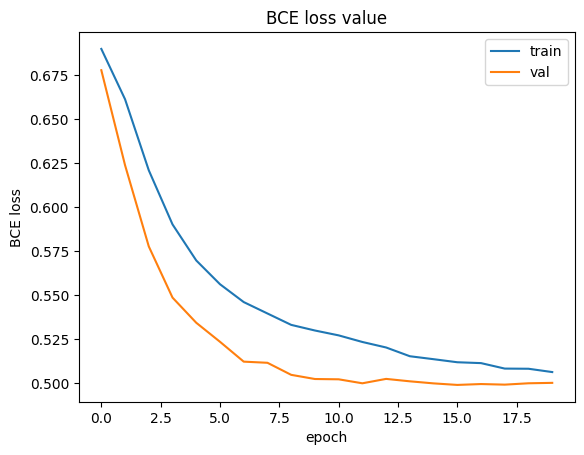

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()